<a href="https://colab.research.google.com/github/priyanka2591/S4/blob/main/Assignment_bn3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [3]:
# this performs the import from the model.py file
import model

from model import BatchNet
from model import LayerNet
from model import GroupNet

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [4]:
train_transforms = transforms.Compose([
                                   transforms.RandomRotation((-12.0, 12.0), fill=(1,)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                   ])

test_transforms = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                                   ])

# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

##### Train and Test functions

In [7]:
# creating the train and
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, lamnda_l1 = 0.01, l1= False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  incorrect = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)
    # Calculate loss----------------------------------------------------------------------------------
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)
    l1 = 0
    if l1 == True:
        for p in model.parameters:
            l1 = l1 + p.abs().sum()
    # adding the l1 loss
        loss = loss + lambda_l1 *l1   
    # --------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # finding out incorrect values
    batch_incorrect = processed - correct
    incorrect  = incorrect + batch_incorrect

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    # return sum(list(train_acc)), sum(list(train_losses))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


#### Batch Net implementation

In [51]:
batch_model = BatchNet().to(device)
summary(batch_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
       BatchNorm2d-6           [-1, 12, 24, 24]              24
            Conv2d-7            [-1, 8, 24, 24]              96
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
      BatchNorm2d-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
      BatchNorm2d-14             [-1, 1

In [52]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


optimizer = optim.SGD(batch_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 15
ta =[]
tl = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(batch_model, device, train_loader, optimizer, epoch, l1 = True)
    ta.append(train_acc)
    tl.append(train_losses)
    scheduler.step()
    test(batch_model, device, test_loader)







  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))






Loss=2.287170886993408 Batch_id=0 Accuracy=12.50:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=2.287170886993408 Batch_id=0 Accuracy=12.50:   0%|          | 1/469 [00:00<01:45,  4.44it/s]





Loss=2.2960944175720215 Batch_id=1 Accuracy=11.33:   0%|          | 1/469 [00:00<01:45,  4.44it/s]





Loss=2.2916746139526367 Batch_id=2 Accuracy=10.94:   0%|          | 1/469 [00:00<01:45,  4.44it/s]





Loss=2.2916746139526367 Batch_id=2 Accuracy=10.94:   1%|          | 3/469 [00:00<01:22,  5.67it/s]





Loss=2.2697947025299072 Batc


Test set: Average loss: 0.0725, Accuracy: 9800/10000 (98.00%)

EPOCH: 1








Loss=0.09619665145874023 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.09619665145874023 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:12,  3.54it/s]





Loss=0.11522780358791351 Batch_id=1 Accuracy=96.88:   0%|          | 1/469 [00:00<02:12,  3.54it/s]





Loss=0.06840281933546066 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<02:12,  3.54it/s]





Loss=0.08848510682582855 Batch_id=3 Accuracy=97.46:   0%|          | 1/469 [00:00<02:12,  3.54it/s]





Loss=0.08848510682582855 Batch_id=3 Accuracy=97.46:   1%|          | 4/469 [00:00<01:36,  4.81it/s]





Loss=0.09673896431922913 Batch_id=4 Accuracy=97.81:   1%|          | 4/469 [00:00<01:36,  4.81it/s]





Loss=0.05349375307559967 Batch_id=5 Accuracy=97.92:   1%|          | 4/469 [00:00<01:36,  4.81it/s]





Loss=0.100026935338974 Batch_id=6 Accuracy=97.88:   1%|          | 4/469 [00:00<01:36,  4.81it/s]  





Loss=0.07501983642578125 Batch_id=7 Accuracy=97.85:   1%|


Test set: Average loss: 0.0570, Accuracy: 9839/10000 (98.39%)

EPOCH: 2





Loss=0.16954196989536285 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]


Loss=0.16954196989536285 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<02:17,  3.40it/s]


Loss=0.08071837574243546 Batch_id=1 Accuracy=96.88:   0%|          | 1/469 [00:00<02:17,  3.40it/s]


Loss=0.06307844817638397 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<02:17,  3.40it/s]


Loss=0.04406573995947838 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<02:17,  3.40it/s]


Loss=0.04406573995947838 Batch_id=3 Accuracy=97.85:   1%|          | 4/469 [00:00<01:40,  4.63it/s]


Loss=0.10982029885053635 Batch_id=4 Accuracy=97.50:   1%|          | 4/469 [00:00<01:40,  4.63it/s]


Loss=0.10898478329181671 Batch_id=5 Accuracy=97.53:   1%|          | 4/469 [00:00<01:40,  4.63it/s]


Loss=0.10898478329181671 Batch_id=5 Accuracy=97.53:   1%|▏         | 6/469 [00:00<01:17,  5.99it/s]


Loss=0.07910461723804474 Batch_id=6 Accuracy=97.43:   1%|▏         | 6/469 [00:00<01:17


Test set: Average loss: 0.0375, Accuracy: 9884/10000 (98.84%)

EPOCH: 3






Loss=0.027980316430330276 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]



Loss=0.027980316430330276 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:53,  4.12it/s]



Loss=0.04221538454294205 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<01:53,  4.12it/s] 



Loss=0.08467520028352737 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<01:53,  4.12it/s]



Loss=0.08467520028352737 Batch_id=2 Accuracy=98.18:   1%|          | 3/469 [00:00<01:27,  5.32it/s]



Loss=0.03251206874847412 Batch_id=3 Accuracy=98.63:   1%|          | 3/469 [00:00<01:27,  5.32it/s]



Loss=0.03334445878863335 Batch_id=4 Accuracy=98.75:   1%|          | 3/469 [00:00<01:27,  5.32it/s]



Loss=0.04129212722182274 Batch_id=5 Accuracy=98.70:   1%|          | 3/469 [00:00<01:27,  5.32it/s]



Loss=0.04129212722182274 Batch_id=5 Accuracy=98.70:   1%|▏         | 6/469 [00:00<01:06,  6.96it/s]



Loss=0.05718099698424339 Batch_id=6 Accuracy=98.55:   1%|▏         | 6/469


Test set: Average loss: 0.0327, Accuracy: 9905/10000 (99.05%)

EPOCH: 4






Loss=0.00949193723499775 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]



Loss=0.00949193723499775 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:00,  2.60it/s]



Loss=0.03855424374341965 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<03:00,  2.60it/s] 



Loss=0.01907939836382866 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<03:00,  2.60it/s]



Loss=0.017353469505906105 Batch_id=3 Accuracy=99.61:   0%|          | 1/469 [00:00<03:00,  2.60it/s]



Loss=0.017353469505906105 Batch_id=3 Accuracy=99.61:   1%|          | 4/469 [00:00<02:10,  3.56it/s]



Loss=0.1432182937860489 Batch_id=4 Accuracy=98.91:   1%|          | 4/469 [00:00<02:10,  3.56it/s]  



Loss=0.022741280496120453 Batch_id=5 Accuracy=98.96:   1%|          | 4/469 [00:00<02:10,  3.56it/s]



Loss=0.022741280496120453 Batch_id=5 Accuracy=98.96:   1%|▏         | 6/469 [00:00<01:38,  4.69it/s]



Loss=0.01622500643134117 Batch_id=6 Accuracy=99.11:   1%|▏         | 


Test set: Average loss: 0.0290, Accuracy: 9907/10000 (99.07%)

EPOCH: 5






Loss=0.02813989669084549 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]



Loss=0.02813989669084549 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:27,  2.26it/s]



Loss=0.04840537905693054 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<03:27,  2.26it/s]



Loss=0.09042911231517792 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<03:27,  2.26it/s]



Loss=0.08343934267759323 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<03:27,  2.26it/s]



Loss=0.08343934267759323 Batch_id=3 Accuracy=98.24:   1%|          | 4/469 [00:00<02:29,  3.12it/s]



Loss=0.0486067458987236 Batch_id=4 Accuracy=98.44:   1%|          | 4/469 [00:00<02:29,  3.12it/s] 



Loss=0.033510658890008926 Batch_id=5 Accuracy=98.44:   1%|          | 4/469 [00:00<02:29,  3.12it/s]



Loss=0.029966140165925026 Batch_id=6 Accuracy=98.44:   1%|          | 4/469 [00:00<02:29,  3.12it/s]



Loss=0.029966140165925026 Batch_id=6 Accuracy=98.44:   1%|▏         | 7/469


Test set: Average loss: 0.0238, Accuracy: 9937/10000 (99.37%)

EPOCH: 6






Loss=0.054708171635866165 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]



Loss=0.054708171635866165 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:35,  2.17it/s]



Loss=0.10389558970928192 Batch_id=1 Accuracy=97.66:   0%|          | 1/469 [00:00<03:35,  2.17it/s] 



Loss=0.018679218366742134 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<03:35,  2.17it/s]



Loss=0.00947507657110691 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<03:35,  2.17it/s] 



Loss=0.00947507657110691 Batch_id=3 Accuracy=98.83:   1%|          | 4/469 [00:00<02:36,  2.98it/s]



Loss=0.03754488378763199 Batch_id=4 Accuracy=98.75:   1%|          | 4/469 [00:00<02:36,  2.98it/s]



Loss=0.03974989056587219 Batch_id=5 Accuracy=98.70:   1%|          | 4/469 [00:00<02:36,  2.98it/s]



Loss=0.03974989056587219 Batch_id=5 Accuracy=98.70:   1%|▏         | 6/469 [00:00<01:56,  3.98it/s]



Loss=0.015859153121709824 Batch_id=6 Accuracy=98.77:   1%|▏         | 6/


Test set: Average loss: 0.0230, Accuracy: 9933/10000 (99.33%)

EPOCH: 7






Loss=0.024172300472855568 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]



Loss=0.024172300472855568 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:18,  2.35it/s]



Loss=0.016756433993577957 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<03:18,  2.35it/s]



Loss=0.014068000949919224 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<03:18,  2.35it/s]



Loss=0.03667353838682175 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<03:18,  2.35it/s] 



Loss=0.03667353838682175 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<02:23,  3.24it/s]



Loss=0.06609773635864258 Batch_id=4 Accuracy=99.22:   1%|          | 4/469 [00:00<02:23,  3.24it/s]



Loss=0.029685325920581818 Batch_id=5 Accuracy=99.09:   1%|          | 4/469 [00:00<02:23,  3.24it/s]



Loss=0.01733245514333248 Batch_id=6 Accuracy=99.11:   1%|          | 4/469 [00:00<02:23,  3.24it/s] 



Loss=0.01733245514333248 Batch_id=6 Accuracy=99.11:   1%|▏         | 7


Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

EPOCH: 8






Loss=0.009516766294836998 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]



Loss=0.009516766294836998 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:44,  2.08it/s]



Loss=0.03331918641924858 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<03:44,  2.08it/s]  



Loss=0.04640519991517067 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<03:44,  2.08it/s]



Loss=0.1237470954656601 Batch_id=3 Accuracy=98.63:   0%|          | 1/469 [00:00<03:44,  2.08it/s] 



Loss=0.1237470954656601 Batch_id=3 Accuracy=98.63:   1%|          | 4/469 [00:00<02:42,  2.87it/s]



Loss=0.042267974466085434 Batch_id=4 Accuracy=98.59:   1%|          | 4/469 [00:00<02:42,  2.87it/s]



Loss=0.05931044742465019 Batch_id=5 Accuracy=98.70:   1%|          | 4/469 [00:00<02:42,  2.87it/s] 



Loss=0.05931044742465019 Batch_id=5 Accuracy=98.70:   1%|▏         | 6/469 [00:00<02:01,  3.82it/s]



Loss=0.06128696724772453 Batch_id=6 Accuracy=98.55:   1%|▏         | 6


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 9






Loss=0.022750278934836388 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]



Loss=0.022750278934836388 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:52,  2.71it/s]



Loss=0.018425872549414635 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:52,  2.71it/s]



Loss=0.018943345174193382 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:52,  2.71it/s]



Loss=0.031379759311676025 Batch_id=3 Accuracy=99.22:   0%|          | 1/469 [00:00<02:52,  2.71it/s]



Loss=0.031379759311676025 Batch_id=3 Accuracy=99.22:   1%|          | 4/469 [00:00<02:06,  3.68it/s]



Loss=0.028337813913822174 Batch_id=4 Accuracy=99.06:   1%|          | 4/469 [00:00<02:06,  3.68it/s]



Loss=0.028115620836615562 Batch_id=5 Accuracy=99.09:   1%|          | 4/469 [00:00<02:06,  3.68it/s]



Loss=0.023257577791810036 Batch_id=6 Accuracy=99.11:   1%|          | 4/469 [00:00<02:06,  3.68it/s]



Loss=0.023257577791810036 Batch_id=6 Accuracy=99.11:   1%|▏         


Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

EPOCH: 10






Loss=0.04411248490214348 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]



Loss=0.04411248490214348 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<03:08,  2.48it/s]



Loss=0.029382677748799324 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<03:08,  2.48it/s]



Loss=0.02438989095389843 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<03:08,  2.48it/s] 



Loss=0.04866688326001167 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<03:08,  2.48it/s]



Loss=0.04866688326001167 Batch_id=3 Accuracy=98.44:   1%|          | 4/469 [00:00<02:17,  3.38it/s]



Loss=0.021639136597514153 Batch_id=4 Accuracy=98.59:   1%|          | 4/469 [00:00<02:17,  3.38it/s]



Loss=0.08253434300422668 Batch_id=5 Accuracy=98.70:   1%|          | 4/469 [00:00<02:17,  3.38it/s] 



Loss=0.08253434300422668 Batch_id=5 Accuracy=98.70:   1%|▏         | 6/469 [00:00<01:43,  4.49it/s]



Loss=0.035937048494815826 Batch_id=6 Accuracy=98.66:   1%|▏         | 6/4


Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)

EPOCH: 11






Loss=0.02757074497640133 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]



Loss=0.02757074497640133 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:17,  2.37it/s]



Loss=0.05153658241033554 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<03:17,  2.37it/s]



Loss=0.015174373984336853 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<03:17,  2.37it/s]



Loss=0.03227110579609871 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<03:17,  2.37it/s] 



Loss=0.03227110579609871 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<02:23,  3.25it/s]



Loss=0.023376362398266792 Batch_id=4 Accuracy=99.06:   1%|          | 4/469 [00:00<02:23,  3.25it/s]



Loss=0.0263570174574852 Batch_id=5 Accuracy=98.96:   1%|          | 4/469 [00:00<02:23,  3.25it/s]  



Loss=0.0263570174574852 Batch_id=5 Accuracy=98.96:   1%|▏         | 6/469 [00:00<01:46,  4.33it/s]



Loss=0.04969091713428497 Batch_id=6 Accuracy=98.66:   1%|▏         | 6/469

KeyboardInterrupt: ignored

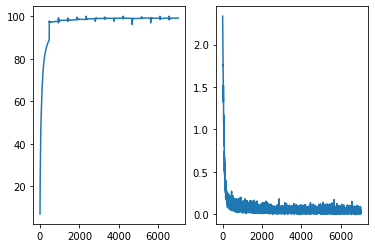

In [17]:
plt.subplot(1,2,1)
plt.plot(train_acc)
plt.subplot(1,2,2)
plt.plot(train_losses)


##### Layer model

In [9]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


layer_model = LayerNet().to(device)
summary(layer_model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
         GroupNorm-6           [-1, 12, 24, 24]              24
            Conv2d-7            [-1, 8, 24, 24]              96
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
        GroupNorm-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
        GroupNorm-14             [

In [18]:
optimizer = optim.SGD(layer_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(layer_model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(layer_model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
         GroupNorm-6           [-1, 12, 24, 24]              24
            Conv2d-7            [-1, 8, 24, 24]              96
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
        GroupNorm-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
        GroupNorm-14             [-1, 1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.08045806735754013 Batch_id=468 Accuracy=86.63: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0784, Accuracy: 9794/10000 (97.94%)

EPOCH: 1


Loss=0.1926385760307312 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9854/10000 (98.54%)

EPOCH: 2


Loss=0.03205862268805504 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.027763856574892998 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.08255388587713242 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.03911568596959114 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.012739269994199276 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.019939478486776352 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.03171562775969505 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.02918251045048237 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.006081061437726021 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.020840466022491455 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.011327727697789669 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.017334818840026855 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.014486707746982574 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]



Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)



##### Group normalization

In [28]:
group_model = GroupNet().to(device)
summary(group_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
         GroupNorm-6           [-1, 12, 24, 24]              24
            Conv2d-7            [-1, 8, 24, 24]              96
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
        GroupNorm-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
        GroupNorm-14             [-1, 1

In [12]:
optimizer = optim.SGD(group_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(group_model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(group_model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
         GroupNorm-6           [-1, 12, 24, 24]              24
            Conv2d-7            [-1, 8, 24, 24]              96
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
        GroupNorm-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
        GroupNorm-14             [-1, 1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.12374579161405563 Batch_id=468 Accuracy=86.31: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0893, Accuracy: 9750/10000 (97.50%)

EPOCH: 1


Loss=0.026314927265048027 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0583, Accuracy: 9831/10000 (98.31%)

EPOCH: 2


Loss=0.07523234933614731 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9867/10000 (98.67%)

EPOCH: 3


Loss=0.06346209347248077 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9869/10000 (98.69%)

EPOCH: 4


Loss=0.03561898693442345 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.03192941099405289 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.07331002503633499 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.006077084690332413 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 33.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.009832638315856457 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.05119304358959198 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.015730200335383415 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 35.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.03598126396536827 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.042304277420043945 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.05491850897669792 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.03589383140206337 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]



Test set: Average loss: 0.0254, Accuracy: 9928/10000 (99.28%)

